In [1]:
#pip install SimpleITK
#pip install nibabel
# !pip install radiomics
# !pip install pyradiomics

In [2]:
import os
import pandas as pd

import imageio
import nibabel as nib
import scipy.ndimage as ndi
import cv2
import SimpleITK as sitk
from skimage import io
from skimage.measure import find_contours

import math
import numpy as np
import cv2
import SimpleITK as sitk
from skimage import io
from skimage.measure import find_contours

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
#base_url = '/content/drive/MyDrive/Task10_Colon/'
#base_url = 'Task10_Colon/'

#path_to_images = base_url + 'imagesTr/'
#path_to_mask = base_url + 'labelsTr/'
#filenames = os.listdir(path_to_images)
#filenames = [i for i in os.listdir(path_to_images) if not i.startswith(".")]

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
def has_tumor(mask):
    '''
    mask should be a binary 2D array (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    Return True if all pixel values of mask is equal to 0 (mask do not contain tumor)
    '''
    return sum(mask.ravel()) > 0


# remove images params
def get_index_tumor_slice(images, masks):
  '''
    Return index of images/masks where tumor is visible
    images and masks are 2D or 3D array with same dimensions
    masks should contain atleat one slice with tumor
  '''
  tumor_idx = []
  if len(masks.shape) == 3:
    for i in range(0, masks.shape[2]):
      # detect binary mask with no tumor (all pixel equal to 0)
      if has_tumor(masks[:,:,i]):
        tumor_idx.append(i)
  elif len(masks.shape) == 2:
      # detect binary mask with no tumor (all pixel equal to 0)
    if has_tumor(masks[:,:,i]):
      tumor_idx.append(i)

  if not tumor_idx:
    raise ValueError("There must be at least one slice with tumor")
  else:
    return tumor_idx 

In [6]:
def image_picker(min_slice, max_slice):
    '''
    return an array containing (max 18) equidistant index number between min_slice and max_slice
    min_slice and max_slice are interger (min_slice cannot be >= max_slice)
    '''
    row = 3
    col = 6
    picker = math.ceil((max_slice - min_slice)/(row*col))
    index_list = []
    index = min_slice
    
    for i in range(row*col):
      if index < max_slice:
        index_list.append(index)
        index += picker
      else:
        index_list.append(max_slice)
        break
    return index_list


In [7]:
def get_bounding_box(mask, crop_margin=0):
    """
    Return the bounding box of a mask image.
    slightly modify from https://github.com/guillaumefrd/brain-tumor-mri-dataset/blob/master/data_visualization.ipynb
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row + crop_margin
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row + crop_margin
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col + crop_margin
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col + crop_margin
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=0):
    """
    Crop an image to the bounding by forcing a squared image as output.
    from https://github.com/guillaumefrd/brain-tumor-mri-dataset/blob/master/data_visualization.ipynb
    """
    x1, y1, x2, y2 =  bbox
    
    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])
    
    return image[y1:y2, x1:x2]

In [8]:
#base_url = '/content/drive/MyDrive/Task10_Colon/'
base_url = 'Task10_Colon/'

path_to_images = base_url + 'imagesTr/'
path_to_mask = base_url + 'labelsTr/'
filenames = os.listdir(path_to_images)
filenames = [i for i in os.listdir(path_to_images) if not i.startswith(".")]

In [9]:
file = []
nbslice = []
nbslice_tumor = []

# To do check exact number

# for filename in filenames:
#     image_3d = nib.load(os.path.join(path_to_images, filename)).get_fdata()
#     mask_3d = nib.load(os.path.join(path_to_mask, filename)).get_fdata()

#     # check if size mask and image are equal
#     if image_3d.shape[0] != mask_3d.shape[0] or image_3d.shape[1] != mask_3d.shape[1]:
#         print("size different betwenn mask and image")
#        # check if same number of slice in mask and image
#     elif image_3d.shape[2] != image_3d.shape[2]:
#         print("slice number different betwenn mask and image")
#     else:
#         index_tumor = get_index_tumor_slice(image_3d, mask_3d)
#         slice_image = image_3d.shape[2] -1
#         slice_image_with_tumors = len(index_tumor)

#         print("{} : {}/{} : {} total slices, {} slices with tumors)".format(filename, image_3d.shape[0],image_3d.shape[1],slice_image, slice_image_with_tumors))        
#         file.append(filename)
#         nbslice.append(slice_image - slice_image_with_tumors)
#         nbslice_tumor.append(slice_image_with_tumors)
#         df = pd.DataFrame({'name': pd.Series(file), 'nbrslide': pd.Series(nbslice),'nbslice_tumor':pd.Series(nbslice_tumor)})

#df.to_csv("CCR_slides.csv", index=False)


In [10]:
df = pd.read_csv("CCR_slides.csv")
formatted_df = pd.melt(df, id_vars=["name"], value_vars=["nbrslide","nbslice_tumor"], var_name="slice_type")
formatted_df = formatted_df.sort_values(by=["name"])
formatted_df.head()

,name,slice_type,value
0,colon_001.nii.gz,nbrslide,56
126,colon_001.nii.gz,nbslice_tumor,3
1,colon_005.nii.gz,nbrslide,85
127,colon_005.nii.gz,nbslice_tumor,12
214,colon_006.nii.gz,nbslice_tumor,4


In [11]:
import seaborn as sns

data = formatted_df.groupby("slice_type")["value"].sum()

plt.figure(figsize=(16, 8))
plt.subplot(3, 6, 1)
sns.boxplot(x="slice_type",y="value", data=formatted_df)
plt.subplot(3, 6, 2)

labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*2, labels=labels)
plt.title("Slice type", fontsize=14);


In [12]:
import seaborn as sns
# matplotlib histogram
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':100})

#Plot Histogram on x

#data = formatted_df.groupby("slice_type")["value"].sum()
#plt.bar(data,height=1500)
#plt.hist(df['nbrslide'], bins=25)
#plt.gca().set(title='Number of slice by patient', ylabel='Frequency', xlabel='Number of slice')
#plt.show()

# # Plot Histogram on x
# plt.hist(df['nbslice_tumor'], bins=25)
# plt.gca().set(title='Number of slice by patient', ylabel='Frequency', xlabel='Number of slice')
# plt.show()

In [13]:
def plot_bbox_image(images, masks, crop_margin=0, zooming=False):
  '''
    Plot equidistant slices with bounding boxe containing the tumor 
    masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    images and masks are 2D array with same dimensions
  '''

  if len(masks.shape) != 2:
    raise ValueError("only accept one array of 2D dimension")

  xmin, ymin, xmax, ymax = get_bounding_box(masks, crop_margin)

  plt.imshow(images, cmap='gray')
  plt.plot([xmin, xmax], [ymin, ymin], color='red')
  plt.plot([xmax, xmax], [ymin, ymax], color='red')
  plt.plot([xmin, xmin], [ymin, ymax], color='red')
  plt.plot([xmin, xmax], [ymax, ymax], color='red')

  if zooming:
    plt.plot([xmax, 511], [ymax, 511], color='red')
    plt.plot([xmax, 511], [ymin, 0], color='red')

In [14]:
def PlotImage(images, masks=None, show_tumor_only = False, dislay_mode=None):
  '''
    Plot equidistant slices along mask and corresponding images along col/row grid 
    masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    images and masks are 2D or 3D array with same dimensions
    if masks = None, Only images are displayed
    if show_tumor_only = True: Only images containing tumor and/or corresponding masks are displayed
    
    if dislay_mode = 'mask' : Display tumor mask with corresponding images
    if dislay_mode = 'frame' : Display bounding box with corresponding images
    if dislay_mode = 'contour' : Display tumor contour with corresponding images
  '''
  images = np.rot90(images, axes=(0, 1))

  if show_tumor_only:
    images_idx = get_index_tumor_slice(images, masks)
    slices_picker = image_picker(min_slice = images_idx[0], max_slice=images_idx[-1])
  else:
    slices_picker = image_picker(min_slice = 0, max_slice=images.shape[2]-1)

  if masks is not None:
    masks = np.rot90(masks, axes=(0, 1))

  row = 3
  col = 6

  plt.figure(figsize=(16, 8))
  for i, idx in enumerate(slices_picker):
    plt.subplot(row, col, i+1)
    plt.imshow(images[:,:,idx], cmap='gray')

    if masks is not None:
      if dislay_mode == 'mask':
        tumor = np.ma.masked_where(masks[:,:,idx] == False, masks[:,:,idx])
        plt.imshow(tumor, cmap='Set1')
        
      if dislay_mode == 'frame':
        plot_bbox_image(images[:,:,idx], masks[:,:,idx], crop_margin=0, zooming=False)
        
      if dislay_mode == 'contour':
        contours = find_contours(masks[:,:,idx],0)
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
    plt.title(str(idx+1))
    plt.axis('off')


In [15]:
#filename = "colon_027.nii.gz"
#filename = "colon_166.nii.gz"
filename = "colon_106.nii.gz"

image_3d = nib.load(os.path.join(path_to_images, filename)).get_fdata()
mask_3d = nib.load(os.path.join(path_to_mask, filename)).get_fdata()

print(mask_3d.shape)

(512, 512, 93)


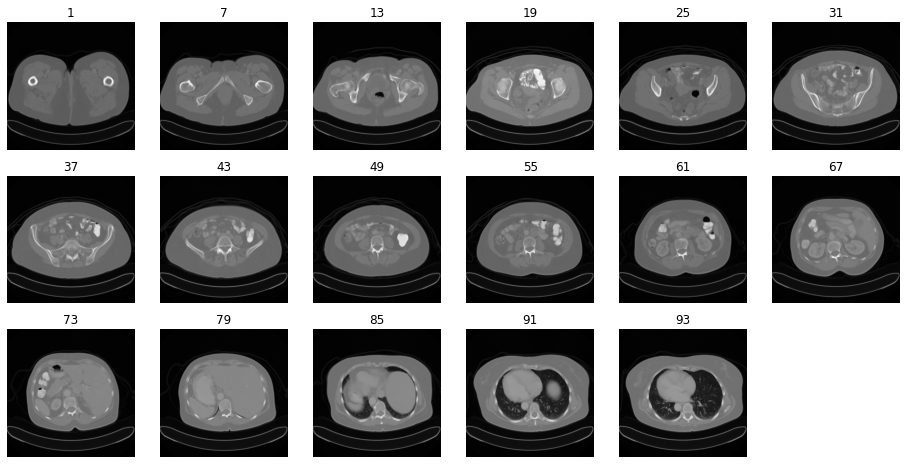

In [16]:
PlotImage(images = image_3d)

/home/hugo/anaconda3/envs/radiomic/lib/python3.9/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hugo/anaconda3/envs/radiomic/lib/python3.9/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/hugo/anaconda3/envs/radiomic/lib/python3.9/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


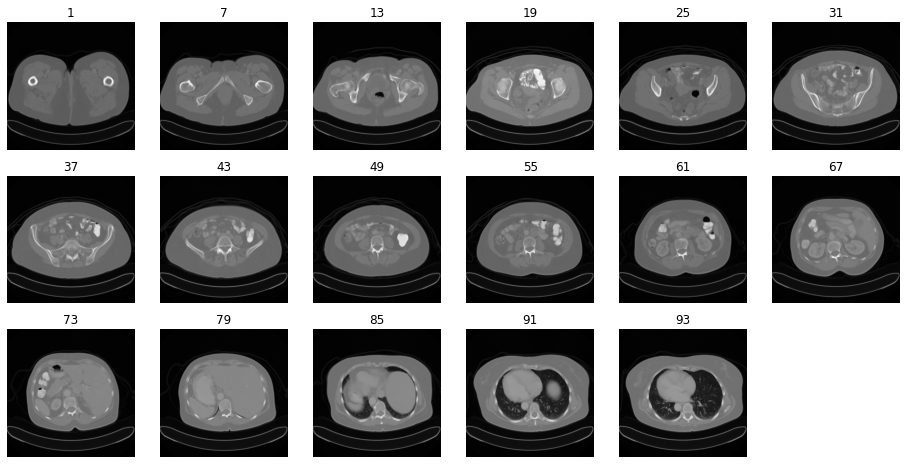

In [17]:
PlotImage(images = image_3d, masks = mask_3d, dislay_mode='mask')

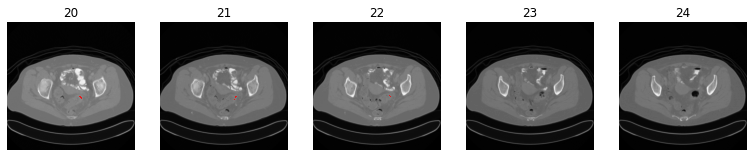

In [18]:
PlotImage(images = image_3d, masks = mask_3d, show_tumor_only = True, dislay_mode='mask')

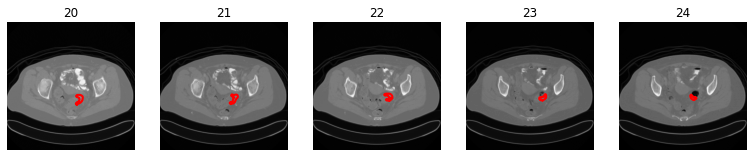

In [19]:
PlotImage(images = image_3d, masks = mask_3d, show_tumor_only = True, dislay_mode='contour')

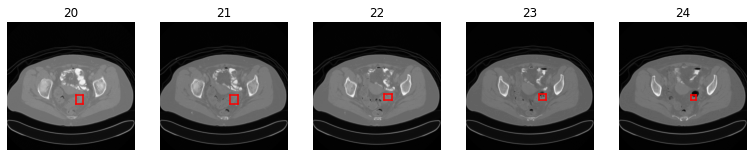

In [20]:
PlotImage(images = image_3d, masks = mask_3d, show_tumor_only = True, dislay_mode='frame')

In [21]:
def biggest_tumor(images, masks):
  
  mask_size = {}

  for idx in range(0, masks.shape[2]):
    if has_tumor(masks[:,:,idx]):
      mask_size[idx+1] = sum(masks[:,:,idx].ravel())
  return max(mask_size, key=mask_size.get)


In [22]:
def plot_tumor(images, masks, idx, save=False):

  mpl.rcParams.update(mpl.rcParamsDefault)
  row = 3
  col = 6
  idx -= 1

  images = np.rot90(image_3d[:,:,idx], axes=(0, 1))
  masks = np.rot90(mask_3d[:,:,idx], axes=(0, 1))

  fig = plt.figure(figsize=(20, 12))
  plt.subplot(row, col, 1)

  plot_bbox_image(images, masks, crop_margin = 10, zooming=True)
  params = {'axes.edgecolor':'red', 'axes.linewidth' : 2}
  plt.rcParams.update(params)

  plt.subplot(row, col, 2)
  bbox = get_bounding_box(masks)
  croped_image = crop_to_bbox(images, bbox, crop_margin=10)
  croped_image = cv2.resize(croped_image, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
  croped_masks = crop_to_bbox(masks, bbox, crop_margin=10)
  croped_masks = cv2.resize(croped_masks, dsize=(512,512), interpolation=cv2.INTER_CUBIC)

  #contours = find_contours(croped_masks,1)
  #for contour in contours:
    #plt.plot(contour[:, 1], contour[:, 0], linewidth=3, c='r')
  #plt.imshow(croped_image, cmap='gray')

  plt.imshow(croped_image, cmap='gray')
  plt.tick_params(axis='both',length=0, labelsize=0)

  plt.subplot(row, col, 3)
  croped_masks = crop_to_bbox(masks, bbox, crop_margin=10)
  croped_masks = cv2.resize(croped_masks, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
  croped_tumor = np.ma.masked_where(croped_masks == False, croped_image)
  croped_tumor_background = np.ma.masked_where(croped_masks == True, np.zeros((512, 512)))
  plt.imshow(croped_tumor, cmap='gray')
  plt.imshow(croped_tumor_background, cmap='gray')
  plt.tick_params(axis='both',length=0, labelsize=0)
    
  plt.subplots_adjust(wspace=0.02)
    
  if save:
    fig.savefig('comparison.pdf', dpi=200) 

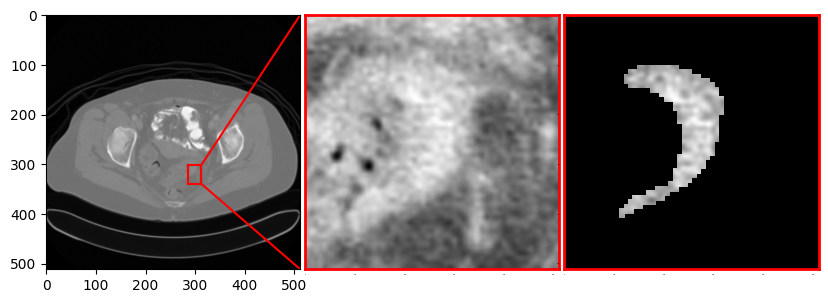

In [23]:
big_tumor = biggest_tumor(image_3d, mask_3d)
plot_tumor(image_3d, mask_3d, big_tumor, save = True)

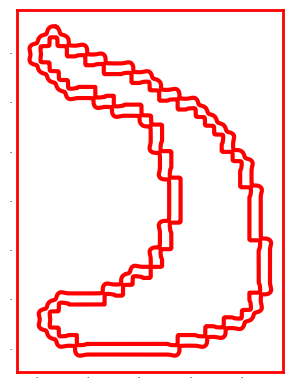

In [24]:
plt.figure(figsize=(24, 16))

kernel = np.ones((5,5),np.float32)/25

idx = 19
row = 3
col = 6

images = np.rot90(image_3d[:,:,idx], axes=(0, 1))
masks = np.rot90(mask_3d[:,:,idx], axes=(0, 1))


plt.subplot(row, col, 2)
bbox = get_bounding_box(masks)

croped_masks = crop_to_bbox(masks, bbox, crop_margin=10)
croped_masks = cv2.resize(croped_masks, dsize=(512,512), interpolation=cv2.INTER_CUBIC)

croped_masks = cv2.filter2D(croped_masks,-1,kernel)
croped_masks = cv2.blur(croped_masks,(1,1))
from skimage.feature import canny

#croped_masks = canny(croped_masks/255.)

contours = find_contours(croped_masks,1)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=3, c='r')

plt.tick_params(axis='both',length=0, labelsize=0)

In [25]:
# def mask_edge(mask):

#   # Apply Sobel filter along both axes
#   sobel_ax0 = ndi.sobel(mask, axis=0)
#   sobel_ax1 = ndi.sobel(mask, axis=1)

#   # Calculate edge magnitude 
#   edges = np.sqrt(np.square(sobel_ax0) + np.square(sobel_ax1))

#   return edges

# bbox = get_bounding_box(mask_3d)
# croped_image = crop_to_bbox(image_3d, bbox, crop_margin=10)

# print(mask_3d[:,:,0].shape)
# print(croped_image.shape)
# i = 0
# row = 1
# col = 3
# idx = 85

# import cv2

# image = image_3d[:,:,idx]
# mask = mask_3d[:,:,idx]

# plt.figure(figsize=(16, 8))
# plt.subplot(row, col, 1)

# plt.imshow(np.rot90(image, axes=(0, 1)), cmap='gray')
# mask = mask_edge(mask)
# tumor = np.ma.masked_where(mask == False, mask)
# plt.imshow(np.rot90(tumor, axes=(0, 1)), cmap='Reds')

# mask = mask_edge(mask)
# croped_mask = crop_to_bbox(mask, bbox, crop_margin=10)
# croped_mask = cv2.resize(croped_mask, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
# croped_tumor = np.ma.masked_where(mask == False, mask)
# plt.imshow(np.rot90(croped_tumor, axes=(0, 1)), cmap='Reds', vmax = 2)

# plt.subplot(row, col, 2)

# croped_image = crop_to_bbox(image, bbox, crop_margin=10)
# croped_image = cv2.resize(croped_image, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
# plt.imshow(np.rot90(croped_image, axes=(0, 1)), cmap='gray')

# mask = mask_edge(mask)
# croped_mask = crop_to_bbox(mask, bbox, crop_margin=10)
# croped_mask = cv2.resize(croped_mask, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
# croped_tumor = np.ma.masked_where(croped_mask == False, croped_mask)
# plt.imshow(np.rot90(croped_tumor, axes=(0, 1)), cmap='Reds', vmax = 100)

# plt.axis('off')